In [1]:
from dataclasses import dataclass
import os
from dotenv import load_dotenv
import dspy

load_dotenv()

@dataclass
class Config:
    # model configuration
    # base_model: str = "ollama_chat/qwen2.5:32b-instruct-q8_0"
    #base_model: str = "ollama_chat/gemma2:9b-instruct-q8_0"
    # base_model: str = "ollama_chat/llama3.2:1b-instruct-q8_0"
    # base_model: str = "ollama_chat/exaone3.5:2.4b-instruct-q8_0"
    # base_model: str = "ollama_chat/granite3.1-dense:2b-instruct-q8_0"
    # base_model: str = "ollama_chat/granite3.1-moe:3b-instruct-q8_0"
    # base_model:str = "ollama_chat/llama3.2:3b-instruct-q8_0"
    #base_model:str = "ollama_chat/gemma2:27b-instruct-q8_0"
    #base_model: str = "ollama_chat/phi4:14b-q8_0"
    #base_model: str = "ollama_chat/command-r:35b-08-2024-q8_0"
    #base_model: str = "ollama_chat/mistral-small:24b-instruct-2501-q8_0"
    #base_model: str = "ollama_chat/phi4-mini:3.8b-q8_0"
    temperature: float = 1.0
    #base_model: str = "openrouter/deepseek/deepseek-chat"
    #base_model: str = "openrouter/deepseek/deepseek-r1"  # good, slow
    #base_model: str = "openrouter/google/gemini-2.0-flash-001" # good, fast
    #base_model: str = "openrouter/deepseek/deepseek-r1-distill-qwen-32b"
    #base_model: str = "openrouter/perplexity/sonar-reasoning"
    #base_model: str = "openrouter/deepseek/deepseek-r1-distill-llama-70b"
    #base_model: str = "openrouter/openai/gpt-4o-mini"
    base_model: str = "openrouter/meta-llama/llama-3.3-70b-instruct"

    # dataset
    dataset: str = "touche2020"
    delta_threshold = 0.1

    # APIKEY (if using api for teacher)
    api_key: str | None = None


config = Config(
    api_key = os.environ["APIKEY"]
)

if config.base_model.startswith("ollama"):
    # small, locally hosted base model
    lm = dspy.LM(config.base_model, api_base='http://localhost:11434', api_key='', temperature=config.temperature, cache=False)
else:
    lm = dspy.LM(config.base_model, api_key=config.api_key, temperature=config.temperature, cache=False)
dspy.configure(lm=lm)

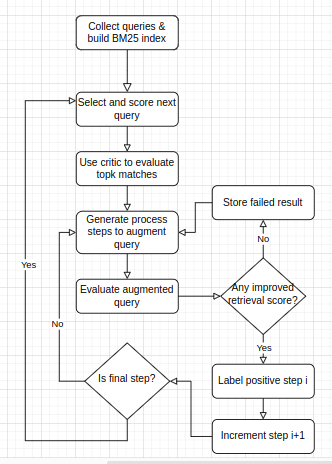

In [2]:
RESULTS_CRITIC = """
Using the query and the retrieved search results,
evaluate topics and/or terms covered by good results and poor results.

Think deeply about what the intention of the query is.
Describe what kind of data the results are (eg. medical documents, academic papers, articles, social media, etc.)

Finally, briefly discuss the strengths and weaknesses of the current results in answering the query.
"""

class CritiqueResults(dspy.Signature):
    __doc__ = RESULTS_CRITIC

    query: str = dspy.InputField(desc="The search query from the user")
    results: list[str] = dspy.InputField(desc="Top scored results retrived from the search")
    document_types: str = dspy.OutputField(desc="What kind of documents are in the index?")
    strengths_weaknesses: str = dspy.OutputField(desc="Strengths and weaknesses of results in answering query")

## Generator 1: Mind Expansion

In [3]:
MIND_EXPANSION = """
Your task is to enhance a given search query by discovering new, relevant documents across various domains.
The augmented query should be novel and free from overlapping the original terms.

### Guidelines:
- **Be Specific and Diverse:** Focus on targeted expansions that introduce new dimensions to the query.
- **Apply Varied Augmentation Techniques:**
  - Synonym Replacement, Conceptual Expansion, Contextual Expansion, Domain-Specific Terminology

### Task Structure:
Complete the following four tasks, avoiding generic or general statements.
Return specific task outcomes only, do not reiterate the task.
We are interested in the results, not the plan.

#### Task 1: Goal Elucidation & Gaps - Examine the original query to understand its primary objectives and gaps
#### Task 2: Ineffective Term Identification - List broad or non-precise terms that should be avoided
#### Task 3: Breadth Expansion - List candidate terms with increasingly distant concepts to the original query
#### Task 4: Depth Expansion - Choose one distant but important topic from the breadth expansion, and go increasingly deeper in the related terms on that one selection

### Final Output:
Return the `augmented_query` from the final task outcome, ensuring it contains only high-quality search terms:
- **No Logical Operators:** Do not use AND/OR.
- **Unique:** Include only unique words without duplication.
- **Diverse:** Target non-overlapping results from the original query.
- **Relevant:** Contextually or peripherally relevant to the original query.
- **Targeted:** Primarily terms from depth expansion with additional high-relevance terms
- **Precision:** Be certain to omit any ineffective words or terms, even if they are included used in the expanded terms.
"""


In [4]:
class GenerateExpansion(dspy.Signature):
    __doc__ = MIND_EXPANSION
    
    query: str = dspy.InputField(desc="The original search query")
    document_types: str = dspy.InputField(desc="The type of documents in the index")
    strengths_weaknesses: str = dspy.InputField(desc="Strengths and weaknesses of existing results")
    #task_outcomes: list[str] = dspy.OutputField(desc="Completed task outcomes")
    query_goals: list[str] = dspy.OutputField(desc="Task 1 list query goals")
    ineffective_terms: list[str] = dspy.OutputField(desc="Task 2 Ineffective query terms")
    breadth_expansion: list[str] = dspy.OutputField(desc="Task 3 Breadth expansion")
    depth_chain: list[str] = dspy.OutputField(desc="Task 4 Depth chain")
    augmented_query: str = dspy.OutputField(desc="Augmented query terms")

## Generator 2: Mind Graph

In [5]:
# MIND_GRAPH = """
# Your task is to enhance a given search query by discovering new, relevant documents across various domains.
# The augmented query should be novel and free from overlapping the original terms.
# You will accomplish this by constructing a "mind graph".

# ### Guidelines:
# - **Be Specific and Diverse:** Focus on targeted expansions that introduce new dimensions to the query.
# - **Apply Varied Augmentation Techniques:**
#   - Synonym Replacement, Conceptual Expansion, Contextual Expansion, Domain-Specific Terminology

# ### Task Structure:
# Complete the following four tasks, avoiding generic or general statements.
# Return specific task outcomes only, do not reiterate the task.
# We are interested in the results, not the plan.

# #### Task 1: Goal Elucidation & Gaps - Examine the original query to understand its primary objectives and gaps
# #### Task 2: Taxonomy - Imagine that the data is co-located in an ideal graph. List the node labels/classes that are in this graph
# #### Task 3: Locate Query Nodes - Using this taxonomy, create a list of nodes that can be identified from the query
# #### Task 4: Nearest Neighbors - Use the taxonomy to comprehensively identify the nearest neighbors to these query nodes

# ### Final Output:
# Return the `augmented_query` from the final task outcome, ensuring it contains only high-quality search terms:
# - **No Logical Operators:** Do not use AND/OR.
# - **Unique:** Include only unique words without duplication.
# - **Diverse:** Target non-overlapping results from the original query.
# - **Relevant:** Contextually or peripherally relevant to the original query.
# - **Targeted:** Primarily terms from depth expansion with additional high-relevance terms
# - **Precision:** Be certain to omit any ineffective words or terms, even if they are included used in the expanded terms.
# """

MIND_GRAPH = """
# Query Expansion via Conceptual Graph Traversal

Your task is to enhance a search query by discovering semantically relevant terms that will improve document retrieval. You'll construct a conceptual graph and traverse it to find high-value expansion terms.

## Process:

### 1. Query Analysis
- Identify core concepts and entities in the original query
- Determine the search intent (informational, navigational, transactional)
- List any implicit assumptions or constraints

### 2. Graph Construction
- Build a conceptual graph with these components:
  a) Core nodes: Direct entities/concepts from the query
  b) First-order connections: Direct properties, attributes, and relationships
  c) Second-order connections: Related concepts one step removed
  d) Domain contexts: Specialized fields where this query has meaning

### 3. Expansion Path Selection
- Identify 3-5 promising directions for query expansion:
  a) Synonymous terms (same meaning, different words)
  b) Hierarchical terms (broader/narrower concepts)
  c) Compositional terms (parts, components, attributes)
  d) Contextual terms (settings, scenarios, applications)
  e) Domain-specific terminology (field-specific variants)

### 4. Term Extraction and Filtering
- For each expansion path, extract 3-5 high-value terms
- Filter terms using these criteria:
  a) Relevance: Strong semantic connection to original query
  b) Distinctiveness: Low lexical overlap with original terms
  c) Specificity: Precise rather than general
  d) Searchability: Likely to appear in relevant documents

## Output Format:
1. Original Query: [exact original query]
2. Core Concepts: [list of 3-5 central concepts]
3. Expansion Paths: [list selected expansion directions with justification]
4. Expanded Terms: [final set of 10-20 high-quality expansion terms]
5. Augmented Query: [original query + weighted selection of best expansion terms]

Ensure your expanded terms maintain the original search intent while providing valuable alternative pathways for retrieval.
"""

In [6]:
class GenerateGraph(dspy.Signature):
    __doc__ = MIND_GRAPH
    
    query: str = dspy.InputField(desc="The original search query")
    document_types: str = dspy.InputField(desc="The type of documents in the index")
    strengths_weaknesses: str = dspy.InputField(desc="Strengths and weaknesses of existing results")
    query_goals: list[str] = dspy.OutputField(desc="Task 1 list query goals")
    node_classes: list[str] = dspy.OutputField(desc="Task 2 taxonomy - list node classes")
    query_nodes: list[str] = dspy.OutputField(desc="Task 3 expansion - list nodes entities from the query")
    nearest_neighbors: list[str] = dspy.OutputField(desc="Task 4 nearest neighbors - list hypothetical nearest neighbors")
    augmented_query: str = dspy.OutputField(desc="Augmented query terms")

## Generator 3: Imaginary Headlines

In [7]:
# IMAGINARY_HEADLINES = """
# Your task is to enhance a given search query by discovering new, relevant documents across various domains.
# The augmented query should be novel and free from overlapping the original terms.
# You will act as an expert investigative journalist, and accomplish this by creating imaginary news headlines.

# ### Guidelines:
# - **Be Specific and Diverse:** Focus on targeted expansions that introduce new dimensions to the query.
# - **Apply Varied Augmentation Techniques:**
#   - Synonym Replacement, Conceptual Expansion, Contextual Expansion, Domain-Specific Terminology

# ### Task Structure:
# Complete the following four tasks, avoiding generic or general statements.
# Return specific task outcomes only, do not reiterate the task.
# We are interested in the results, not the plan.

# #### Task 1: Goal Elucidation & Gaps - Examine the original query to understand its primary objectives and gaps
# #### Task 2: Important events - Brainstorm unique, important events that might be peripherally related to the query
# #### Task 3: Investigative journalism - Investigate these events in your mind and list the important related entities to interrogate
# #### Task 4: Headlines - Write a set of headlines to capture these notable occurrences

# ### Final Output:
# Return the `augmented_query` from the final task outcome, ensuring it contains only high-quality search terms:
# - **No Logical Operators:** Do not use AND/OR.
# - **Unique:** Include only unique words without duplication.
# - **Diverse:** Target non-overlapping results from the original query.
# - **Relevant:** Contextually or peripherally relevant to the original query.
# - **Targeted:** Primarily terms from depth expansion with additional high-relevance terms
# - **Precision:** Be certain to omit any ineffective words or terms, even if they are included used in the expanded terms.
# """
NEWSROOM_EXPANSION = """
# Query Expansion Through Journalistic Investigation

Your task is to enhance any search query by applying investigative research techniques to discover related real-world terms and concepts.
Approach every query—whether a question, how-to, or topic—as if you're a researcher building a comprehensive story on the subject.

## Process:

### 1. Query Assessment
- Analyze what the user is truly seeking beneath the surface query
- Identify assumptions, knowledge gaps, and unexpressed needs
- Determine if the query is seeking practical advice, factual information, conceptual understanding, or something else

### 2. Real-World Contexts
- Identify diverse real-world scenarios where this query is relevant:
  a) Professional contexts (workplaces, industries, roles)
  b) Educational settings (academic disciplines, learning environments)
  c) Personal situations (life stages, common challenges)
  d) Specialized communities (experts, practitioners, enthusiasts)
  e) Historical or evolving contexts (how the topic has changed over time)

### 3. Resource Investigation
- Identify real, authoritative sources of information on this topic:
  a) Notable experts and their key contributions
  b) Established methodologies, frameworks, and approaches
  c) Essential terminology and specialized vocabulary
  d) Organizations, institutions, and communities involved
  e) Fundamental concepts and related skills

### 4. Headline Creation
- Create diverse headlines that could introduce articles addressing the query from multiple angles:
  a) Beginner-oriented explanations
  b) Expert-level deep dives
  c) Practical application guides
  d) Comparative analyses
  e) Historical or future-focused perspectives

### 5. Term Extraction
- Extract specific terms from your headlines that:
  a) Represent precise concepts related to the query
  b) Include terminology experts would use
  c) Cover related topics and peripheral areas
  d) Reference specific methodologies, tools, or approaches
  e) Filter out generic words in favor of distinctive terms

## Output Format:
- Query Goals: List the deeper information needs behind the query
- Important Contexts: Identify real situations where this query matters
- Key Resources: List experts, concepts, methodologies, and organizations to explore
- Headlines: Create diverse article headlines addressing different aspects
- Extracted Terms: Pull out specific, high-value search terms
- Augmented Query: Combine original query intent with these valuable new terms

Remember: Your goal is to uncover legitimate, real-world terms that would appear in high-quality content about this topic, regardless of whether it's technical, educational, practical, or theoretical.
"""

In [8]:
class GenerateHeadlines(dspy.Signature):
    __doc__ = NEWSROOM_EXPANSION
    
    query: str = dspy.InputField(desc="The original search query")
    document_types: str = dspy.InputField(desc="The type of documents in the index")
    strengths_weaknesses: str = dspy.InputField(desc="Strengths and weaknesses of existing results")
    
    query_goals: list[str] = dspy.OutputField(desc="Task 1: Identify query objectives and information gaps")
    important_events: list[str] = dspy.OutputField(desc="Task 2: List potential events related to the query topic")
    questions: list[str] = dspy.OutputField(desc="Task 3: List key entities and relationships to investigate")
    headlines: list[str] = dspy.OutputField(desc="Task 4: Create diverse news headlines about the query topic")
    extracted_terms: list[str] = dspy.OutputField(desc="Task 5: Extract informative terms from headlines")
    augmented_query: str = dspy.OutputField(desc="Augmented query terms")

## Generator 4: Expert Panel

In [9]:
EXPERT_PANEL = """
# Query Expansion via Multi-Disciplinary Expert Panel

Imagine convening a panel of 5 diverse experts from different disciplines to analyze this query. Each expert will contribute specialized knowledge, terminology, and perspectives.

## Process:

### 1. Expert Selection
- Identify 5 relevant disciplines for this query (e.g., technical, academic, practical, historical, social)
- For each discipline, create an expert persona with specific credentials and experience

### 2. Individual Consultations
- Each expert analyzes the query from their disciplinary perspective
- They identify key concepts, methodologies, and specialized vocabulary
- They note what the original query might be overlooking from their expertise

### 3. Panel Discussion
- Experts debate different approaches to the query
- They identify cross-disciplinary connections
- They highlight complementary tools and frameworks
- They clarify terminology differences between fields

### 4. Recommendations
- Each expert provides 3-5 recommended resources most valuable for this query
- They contribute domain-specific search terms
- They suggest specific concepts to explore further

### 5. Term Synthesis
- Compile specialized terminology from all experts
- Identify terms with cross-disciplinary relevance
- Prioritize terms that add new dimensions to the search

Output each expert's contribution, then synthesize their insights into an expanded query.
"""

class ExpertPanel(dspy.Signature):
    __doc__ = EXPERT_PANEL
    
    query: str = dspy.InputField(desc="The original search query")
    document_types: str = dspy.InputField(desc="The type of documents in the index")
    strengths_weaknesses: str = dspy.InputField(desc="Strengths and weaknesses of existing results")
    
    selected_experts: list[str] = dspy.OutputField(desc="Task 1: List five expert personas from relevant disciplines")
    expert_insights: list[str] = dspy.OutputField(desc="Task 2: Key insights from each expert's perspective")
    cross_connections: list[str] = dspy.OutputField(desc="Task 3: Cross-disciplinary connections from discussion")
    recommended_resources: list[str] = dspy.OutputField(desc="Task 4: Specific resources and concepts recommended")
    extracted_terms: list[str] = dspy.OutputField(desc="Task 5: Specialized terminology from all experts")
    augmented_query: str = dspy.OutputField(desc="Augmented query terms")

## Generator 5: Temporal Evolution

In [10]:
TIME_TRAVELER = """
# Query Expansion via Temporal Evolution Analysis

Analyze how the query topic has evolved through time and will likely develop in the future to discover temporally diverse terminology.

## Process:

### 1. Historical Foundation
- Trace the origins and early development of this topic
- Identify foundational concepts and terminology
- Note historical approaches and methodologies now considered classic

### 2. Developmental Milestones
- Map key evolutionary stages in the topic's development
- Identify breakthrough moments that changed terminology or approaches
- Note how language and concepts have transformed over time

### 3. Current Landscape
- Assess the contemporary state of this topic
- Identify current best practices and leading approaches
- Map the terminology used by today's practitioners and experts

### 4. Emerging Horizons
- Project how this topic is likely to evolve
- Identify emerging trends, technologies, or approaches
- Note new terminology that is gaining acceptance

### 5. Temporal Term Extraction
- Compile terminology from each time period
- Identify terms that have remained relevant across eras
- Select terms that provide historical context or future relevance

Output a timeline of the topic's evolution, then extract terms that represent its full temporal spectrum.
"""

class TimeTravel(dspy.Signature):
    __doc__ = TIME_TRAVELER
    
    query: str = dspy.InputField(desc="The original search query")
    document_types: str = dspy.InputField(desc="The type of documents in the index")
    strengths_weaknesses: str = dspy.InputField(desc="Strengths and weaknesses of existing results")
    
    historical_foundation: list[str] = dspy.OutputField(desc="Task 1: Origins and foundational concepts")
    development_milestones: list[str] = dspy.OutputField(desc="Task 2: Key evolutionary stages and breakthroughs")
    current_landscape: list[str] = dspy.OutputField(desc="Task 3: Contemporary state and terminology")
    emerging_trends: list[str] = dspy.OutputField(desc="Task 4: Future developments and emerging terms")
    temporal_terms: list[str] = dspy.OutputField(desc="Task 5: Terms representing the full temporal spectrum")
    augmented_query: str = dspy.OutputField(desc="Augmented query terms")

## Generator 6: Metaphorical Mapping

In [11]:
METAPHOR_WORKSHOP = """
# Query Expansion via Metaphorical Thinking

Generate powerful metaphors for the query topic and mine them for conceptually related terminology from diverse domains.

## Process:

### 1. Metaphor Generation
- Create 5 diverse metaphors for understanding this topic
- Select metaphors from varied domains (nature, mechanics, art, etc.)
- Develop each metaphor with specific correspondences

### 2. Domain Mapping
- For each metaphor, map elements from the source domain to the target domain
- Identify which aspects of the metaphor capture key features of the topic
- Note where the metaphors provide complementary perspectives

### 3. Language Exploration
- Extract terminology from each metaphorical domain
- Identify terms that illuminate aspects of the original topic
- Note explanatory language used to connect the domains

### 4. Metaphorical Extension
- Extend each metaphor to discover additional connections
- Push the metaphors to reveal hidden aspects of the topic
- Combine metaphors to create hybrid perspectives

### 5. Cross-Domain Term Extraction
- Compile terminology inspired by each metaphorical domain
- Identify terms that offer fresh perspectives on the topic
- Select terms that make complex aspects more accessible

Output your developed metaphors, then extract terms that provide valuable cross-domain insights.
"""

class MetaphorWorkshop(dspy.Signature):
    __doc__ = METAPHOR_WORKSHOP
    
    query: str = dspy.InputField(desc="The original search query")
    document_types: str = dspy.InputField(desc="The type of documents in the index")
    strengths_weaknesses: str = dspy.InputField(desc="Strengths and weaknesses of existing results")
    
    generated_metaphors: list[str] = dspy.OutputField(desc="Task 1: Five diverse metaphors for the topic")
    domain_mappings: list[str] = dspy.OutputField(desc="Task 2: Element mappings between domains")
    metaphorical_language: list[str] = dspy.OutputField(desc="Task 3: Terminology from each metaphorical domain")
    extended_metaphors: list[str] = dspy.OutputField(desc="Task 4: Extended and hybrid metaphorical perspectives")
    cross_domain_terms: list[str] = dspy.OutputField(desc="Task 5: Terms providing cross-domain insights")
    augmented_query: str = dspy.OutputField(desc="Augmented query terms")

## Generator 7: Concept Cartography

In [12]:
KNOWLEDGE_MAPPING = """
# Query Expansion via Conceptual Territory Mapping

Approach the query as a knowledge cartographer creating a detailed map of the conceptual territory surrounding the topic.

## Process:

### 1. Central Coordinates
- Identify the exact center point of the query
- Establish cardinal directions (practical/theoretical, technical/social, etc.)
- Set the appropriate scale (granular/broad) for exploration

### 2. Boundary Exploration
- Chart the boundaries of the query's immediate territory
- Identify neighboring domains and disciplines
- Note areas where territories overlap or connect

### 3. Landmark Identification
- Plot major "landmarks" (key concepts, essential resources)
- Identify "settlements" (communities of practice, schools of thought)
- Map "routes" (methodologies, processes, learning pathways)

### 4. Detail Mapping
- Fill in specialized features within each region
- Label with precise, domain-specific terminology
- Note historical sites and emerging developments

### 5. Cartographic Legend
- Create a lexicon of the most important terms on your map
- Classify them by region and significance
- Select terms that would help a traveler navigate this knowledge landscape

Output a visualization of your conceptual map, then extract the most valuable navigation terms.
"""

class ConceptCartography(dspy.Signature):
    __doc__ = KNOWLEDGE_MAPPING
    
    query: str = dspy.InputField(desc="The original search query")
    document_types: str = dspy.InputField(desc="The type of documents in the index")
    strengths_weaknesses: str = dspy.InputField(desc="Strengths and weaknesses of existing results")
    
    central_coordinates: list[str] = dspy.OutputField(desc="Task 1: Central point and dimensions of the concept map")
    boundary_areas: list[str] = dspy.OutputField(desc="Task 2: Boundaries and neighboring domains")
    key_landmarks: list[str] = dspy.OutputField(desc="Task 3: Major landmarks in the knowledge landscape")
    detail_features: list[str] = dspy.OutputField(desc="Task 4: Specialized features within each region")
    navigation_terms: list[str] = dspy.OutputField(desc="Task 5: Important terms from the cartographic legend")
    augmented_query: str = dspy.OutputField(desc="Augmented query terms")

## Generator 8: User Journey

In [13]:
USER_JOURNEY_MAPPING = """
# Query Expansion via User Intent and Journey Mapping

Your task is to expand a search query by analyzing how different users would seek this information throughout their journey from awareness to expertise.

## Process:

### 1. User Persona Creation
- Create 4 distinct user personas with varying:
  a) Expertise levels (novice, intermediate, advanced, expert)
  b) Goals and motivations for seeking this information
  c) Prior knowledge and vocabulary differences
  d) Contexts and situations prompting the search

### 2. Search Vocabulary Analysis
- For each persona, identify:
  a) Initial search terms they would naturally use
  b) Follow-up searches they might try after initial results
  c) How their vocabulary differs based on expertise
  d) Misconceptions or alternative terminology they might employ

### 3. Information Journey Mapping
- Map the progressive information needs as users learn:
  a) Entry-point questions and terminology
  b) Intermediate learning milestones and associated terms
  c) Advanced concept exploration vocabulary
  d) Expert-level terminology for specialized functions

### 4. Contextual Scenarios
- Identify specific scenarios where users need this information:
  a) Problem-solving situations
  b) Learning contexts
  c) Decision-making moments
  d) Practical application settings

### 5. Intent-Based Term Extraction
- From all personas and scenarios, extract:
  a) High-value terms across the expertise spectrum
  b) Contextual vocabulary from different usage scenarios
  c) Intent-revealing terminology that clarifies search purpose
  d) Terms reflecting how users actually describe their needs

Output terms reflecting how real users with diverse backgrounds would search for this information at different stages of their journey.
"""

class UserJourneyMapping(dspy.Signature):
    __doc__ = USER_JOURNEY_MAPPING
    
    query: str = dspy.InputField(desc="The original search query")
    document_types: str = dspy.InputField(desc="The type of documents in the index")
    strengths_weaknesses: str = dspy.InputField(desc="Strengths and weaknesses of existing results")
    
    user_personas: list[str] = dspy.OutputField(desc="Task 1: Four user personas with different needs and expertise")
    search_vocabulary: list[str] = dspy.OutputField(desc="Task 2: How each persona would express their search needs")
    journey_stages: list[str] = dspy.OutputField(desc="Task 3: Progressive information needs and terminology")
    usage_scenarios: list[str] = dspy.OutputField(desc="Task 4: Specific contexts where users need this information")
    intent_terms: list[str] = dspy.OutputField(desc="Task 5: Terms reflecting diverse user intents and needs")
    augmented_query: str = dspy.OutputField(desc="Augmented query terms")

## Generator 9: Community Mapping

In [14]:
COMMUNITY_QA_MAPPING = """
# Query Expansion via Community Q&A Patterns

Your task is to expand a search query by analyzing how it would evolve in a community Q&A platform like Quora, examining both question variations and answer patterns.

## Process:

### 1. Question Reframing
- Reframe the original query as:
  a) Personal experience questions ("What is it like to...")
  b) Advice-seeking questions ("How should I...")
  c) Opinion-based questions ("What do people think about...")
  d) Comparison questions ("Which is better, X or Y for...")
  e) Story-soliciting questions ("Has anyone ever...")

### 2. Hidden Motivations
- Identify what the asker might really be seeking:
  a) Validation or reassurance
  b) Personal decision support
  c) Insider knowledge not found in formal sources
  d) Diverse perspectives on subjective matters
  e) Emotional support or community connection

### 3. Answer Archetypes
- Identify valuable response patterns to target:
  a) First-person experience narratives
  b) Expert opinions with credibility markers
  c) Step-by-step practical advice
  d) Contrarian or alternative viewpoints
  e) Nuanced "it depends" conditional answers

### 4. Community Interactions
- Map typical community dynamics:
  a) Common follow-up questions
  b) Frequently debated aspects
  c) Clarifications people often request
  d) Related questions people also ask
  e) How questions evolve through comments and discussions

### 5. Vocabulary Extraction
- Extract terminology from:
  a) Emotional and subjective language
  b) Personal context descriptions
  c) Informal explanations and analogies
  d) Qualification patterns ("as someone who...")
  e) Community-specific jargon and references

Output terms that reflect how real people discuss this topic in conversational Q&A contexts rather than formal documents.
"""

class CommunityQAMapping(dspy.Signature):
    __doc__ = COMMUNITY_QA_MAPPING
    
    query: str = dspy.InputField(desc="The original search query")
    document_types: str = dspy.InputField(desc="The type of documents in the index")
    strengths_weaknesses: str = dspy.InputField(desc="Strengths and weaknesses of existing results")
    
    question_variations: list[str] = dspy.OutputField(desc="Task 1: Different ways people might ask this question")
    underlying_motivations: list[str] = dspy.OutputField(desc="Task 2: What the asker might really be seeking")
    valuable_responses: list[str] = dspy.OutputField(desc="Task 3: Types of answers people would find helpful")
    interaction_patterns: list[str] = dspy.OutputField(desc="Task 4: How the community would engage with this question")
    qa_terminology: list[str] = dspy.OutputField(desc="Task 5: Terms from conversational Q&A contexts")
    augmented_query: str = dspy.OutputField(desc="Augmented query terms")

# Scorer

In [15]:
import heapq
from typing import Dict, List

def get_topk_ids(data_dict: Dict[str, float], k: int = 5) -> List[str]:
    """
    Retrieve the top k hash IDs from the dictionary based on their values.

    Parameters:
    - data_dict (Dict[str, float]): Dictionary with hash IDs as keys and float values.
    - k (int): Number of top items to retrieve.

    Returns:
    - List[str]: List of top k hash IDs sorted by their values in descending order.
    """
    if k <= 0:
        return []
    
    # If k exceeds the number of items, return all keys sorted by value
    if k >= len(data_dict):
        return sorted(data_dict, key=data_dict.get, reverse=True)
    
    # Use heapq.nlargest to get the top k items efficiently
    topk = heapq.nlargest(k, data_dict.items(), key=lambda item: item[1])
    
    # Extract and return the keys from the top k items
    return [key for key, value in topk]

def get_result_texts(scorer, corpus_keys):
    return [
        f"{scorer.corpus[doc_id]['title']}: {scorer.corpus[doc_id]['text']}"
        for doc_id in corpus_keys
    ]

# Generator

In [16]:
import json
import inspect
from dspy import Example
from dataclasses import dataclass, asdict

# from rrf_scorer import SimpleBM25BeirScorer
# scorer = SimpleBM25BeirScorer(dataset_name=config.dataset)

from nano_bm25_scorer import NanoBM25BeirScorer
scorer = NanoBM25BeirScorer(dataset_name=config.dataset)


class QueryGenerator(dspy.Module):
    def __init__(self, scorer):
        self.critic = dspy.ChainOfThought(CritiqueResults)
        # Original generators
        self.expand = dspy.ChainOfThought(GenerateExpansion)
        self.graph = dspy.ChainOfThought(GenerateGraph)
        self.headline = dspy.ChainOfThought(GenerateHeadlines)
        # New generators
        self.expert = dspy.ChainOfThought(ExpertPanel)
        self.timetravel = dspy.ChainOfThought(TimeTravel)
        self.metaphor = dspy.ChainOfThought(MetaphorWorkshop)
        self.cartography = dspy.ChainOfThought(ConceptCartography)
        self.journey = dspy.ChainOfThought(UserJourneyMapping)
        self.community = dspy.ChainOfThought(CommunityQAMapping)
        
        self.parallel = dspy.Parallel(num_threads=4)
        self.scorer = scorer
        
        # Define generator map for reference
        self.generator_map = {
            0: "expand",
            1: "graph", 
            2: "headline",
            3: "expert",
            4: "timetravel",
            5: "metaphor",
            6: "cartography",
            7: "journey",
            8: "community"
        }

    def save_docstrings_to_json(self, output_file="generator_docstrings.json"):
        """
        Extracts docstrings from ChainOfThought generators and saves them to a JSON file.
        
        Args:
            output_file: Path to the output JSON file.
        
        Returns:
            dict: The extracted docstrings.
        """
        docstrings = {}
        
        # Using generator_map keys to extract relevant docstrings
        for key in self.generator_map.values():
            if hasattr(self, key):
                generator = getattr(self, key)
                # Extract the class from the ChainOfThought
                if hasattr(generator, 'signature'):
                    cls = generator.signature
                    # Get the docstring of the class
                    docstring = inspect.getdoc(cls)
                    docstrings[key] = docstring if docstring else "No docstring available"
        
        # Also add critic since it's important but not in generator_map
        if hasattr(self, 'critic') and hasattr(self.critic, 'lm_class'):
            docstrings['critic'] = inspect.getdoc(self.critic.lm_class) or "No docstring available"
        
        # Save the docstrings to a JSON file
        with open(output_file, 'w') as f:
            json.dump(docstrings, f, indent=4)
        
        print(f"Docstrings saved to {output_file}")
        return docstrings

    def forward(self, query_id: str):
        fusion = self.scorer.FusionRun.init_run(scorer, query_id, shift=0.5)
        query = scorer.get_query_text(query_id)
        print(f"Original query: {query}")
        corpus_keys = get_topk_ids(fusion.runs[0].doc_scores)
        original_results = get_result_texts(scorer, corpus_keys)
        criticism = self.critic(
            query=query,
            results=original_results
        )

        example = Example(
            query=query,
            document_types=criticism.document_types,
            strengths_weaknesses=criticism.strengths_weaknesses,
        ).with_inputs("query", "document_types", "strengths_weaknesses")

        # Create each generator execution pair
        exec_pairs = [
            (self.expand, example),
            (self.graph, example),
            (self.headline, example),
            (self.expert, example),
            (self.timetravel, example),
            (self.metaphor, example),
            (self.cartography, example),
            (self.journey, example),
            (self.community, example)
        ]
        
        expansion = self.parallel.forward(exec_pairs)
        expansion = list(filter(lambda x: x[0] is not None, zip(expansion, range(9))))
        print(f"Generated {len(expansion)} valid expansions")
        
        result = fusion.evaluate_augmented_queries([x.augmented_query for x,_ in expansion], 10000)
        max_item = max(result, key=lambda x: x["delta"])
        pred, idx = expansion[result.index(max_item)]
        
        best_instruction = self.generator_map[idx]
        
        fusion.update_with_run(max_item["candidate_run"])
        final_eval = fusion.evaluate_fused()
        print("Final Delta:", max_item["delta"])
        print("Final Fused - NDCG:", final_eval.ndcg)
        print("Final Fused - MAP:", final_eval.map)
        print("Final Fused - Recall:", final_eval.recall)
        print("Final Fused - Precision:", final_eval.precision)
        print(f"Best generator: {best_instruction}")

        output = pred.toDict()
        output.update(asdict(final_eval))
        output["delta"] = max_item["delta"]
        output["instruction"] = best_instruction
        output["query"] = query
        output["query_id"] = query_id
        output.pop("doc_ids")
        output.pop("scores")
        print(output)
        
        return dspy.Prediction(
            **output
        )

In [17]:
import random
import json
import os
import glob
from tqdm import tqdm

def get_files_to_skip(data_directory=f"data/{config.dataset}", delta_threshold=0.01):
    """
    Get doc_ids to skip:
    1. All existing doc_ids in the directory
    2. Filter out (don't skip) those with:
       - negative delta values
       - delta values below the threshold
       - NDCG@10 that isn't already perfect (1.0)
    
    Args:
        data_directory: Directory containing the JSON files
        delta_threshold: Threshold below which files should be reprocessed
    """
    json_files = glob.glob(os.path.join(data_directory, "*.json"))
    to_skip = set()
    to_reprocess = set()
    perfect_ndcg = set()
    
    for file_path in json_files:
        doc_id = os.path.splitext(os.path.basename(file_path))[0]
        try:
            with open(file_path, 'r') as f:
                data = json.load(f)
                delta = data.get('delta', 0)
                
                # Check if NDCG@10 is perfect (1.0)
                ndcg_is_perfect = False
                if 'ndcg' in data and 'NDCG@10' in data['ndcg']:
                    if data['ndcg']['NDCG@10'] >= 0.9999:  # Using 0.9999 to account for floating point imprecision
                        ndcg_is_perfect = True
                        perfect_ndcg.add(doc_id)
                
                # If delta is negative or below threshold, we want to reprocess this file
                # Unless NDCG is already perfect
                if ndcg_is_perfect:
                    to_skip.add(doc_id)
                elif delta < 0 or delta < delta_threshold:
                    to_reprocess.add(doc_id)
                else:
                    to_skip.add(doc_id)
        except (json.JSONDecodeError, FileNotFoundError):
            # If there's an error reading the file, we'll reprocess it
            to_reprocess.add(doc_id)
    
    print(f"Found {len(to_skip)} files to skip")
    print(f"Found {len(to_reprocess)} files with delta < {delta_threshold} to reprocess")
    print(f"Found {len(perfect_ndcg)} files with perfect NDCG@10 (1.0)")
    return to_skip, to_reprocess

# Initialize your components
gen = QueryGenerator(scorer)
gen.save_docstrings_to_json()
all_query_ids = list(scorer.get_query_ids())

# Get doc_ids to skip and to reprocess with threshold
doc_ids_to_skip, doc_ids_to_reprocess = get_files_to_skip(delta_threshold=config.delta_threshold)

# Filter out query IDs that should be skipped (and not reprocessed)
query_ids_to_process = [
    qid for qid in all_query_ids 
    if qid not in doc_ids_to_skip or qid in doc_ids_to_reprocess
]
print(f"Processing {len(query_ids_to_process)} queries")

# Create data directory if it doesn't exist
data_directory = f"data/{config.dataset}"
os.makedirs(data_directory, exist_ok=True)

# Process the queries with tqdm progress bar
for query_id in tqdm(query_ids_to_process, desc="Processing queries"):
    file_path = os.path.join(data_directory, f"{query_id}.json")
    
    # Check if file exists and get existing delta and NDCG
    existing_delta = None
    existing_ndcg_perfect = False
    
    if os.path.exists(file_path):
        try:
            with open(file_path, 'r') as f:
                existing_data = json.load(f)
                existing_delta = existing_data.get('delta', None)
                
                # Check if existing NDCG@10 is perfect
                if 'ndcg' in existing_data and 'NDCG@10' in existing_data['ndcg']:
                    if existing_data['ndcg']['NDCG@10'] >= 0.9999:  # Account for floating point imprecision
                        existing_ndcg_perfect = True
                        print(f"Skipping {query_id} - already has perfect NDCG@10")
                        continue  # Skip to next query_id
        except (json.JSONDecodeError, FileNotFoundError):
            # If there's an error reading the file, treat as if it doesn't exist
            pass
    
    # Generate new prediction
    pred = gen(query_id)
    
    # Only save if prediction is valid
    if pred is not None:
        pred_dict = pred.toDict()
        new_delta = pred_dict.get('delta', 0)
        
        # Check if new prediction has perfect NDCG
        new_ndcg_perfect = False
        if 'ndcg' in pred_dict and 'NDCG@10' in pred_dict['ndcg']:
            if pred_dict['ndcg']['NDCG@10'] >= 0.9999:
                new_ndcg_perfect = True
                print(f"Generated perfect NDCG@10 for {query_id}")
        
        # Save only if:
        # 1. No existing file with valid delta, or
        # 2. New delta is better than existing delta, or
        # 3. New prediction has perfect NDCG and existing doesn't
        should_save = (
            existing_delta is None or 
            new_delta > existing_delta or
            (new_ndcg_perfect and not existing_ndcg_perfect)
        )
        
        if should_save:
            # Add query_id and dataset info
            pred_dict["query_id"] = query_id
            pred_dict["dataset"] = config.dataset
            pred_dict["generator_model"] = config.base_model
            pred_dict["temperature"] = config.temperature
            
            # Save the dictionary to a JSON file
            with open(file_path, "w") as fh:
                json.dump(pred_dict, fh)
            
            if existing_delta is not None:
                print(f"Improved delta for {query_id}: {existing_delta} → {new_delta}")
        else:
            print(f"Keeping existing file for {query_id} (existing delta: {existing_delta}, new delta: {new_delta})")

print("Processing complete")

Docstrings saved to generator_docstrings.json
Found 7 files to skip
Found 42 files with delta < 0.1 to reprocess
Found 3 files with perfect NDCG@10 (1.0)
Processing 42 queries


Processing queries:   0%|                                                                                                                                                                                                | 0/42 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Original query: Is homework beneficial?

Processed 9 / 9 examples: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:50<00:00,  5.65s/it]
Generated 9 valid expansions


Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Processing queries:   2%|████▍                                                                                                                                                                                   | 1/42 [01:05<44:44, 65.49s/it]

Final Delta: 0.011369999999999991
Final Fused - NDCG: {'NDCG@10': 0.77216, 'NDCG@100': 0.68502, 'NDCG@1000': 0.80157, 'NDCG@10000': 0.81224}
Final Fused - MAP: {'MAP@10': 0.24109, 'MAP@100': 0.40965, 'MAP@1000': 0.45232, 'MAP@10000': 0.45274}
Final Fused - Recall: {'Recall@10': 0.26923, 'Recall@100': 0.69231, 'Recall@1000': 0.96154, 'Recall@10000': 1.0}
Final Fused - Precision: {'P@10': 0.7, 'P@100': 0.18, 'P@1000': 0.025, 'P@10000': 0.0026}
Best generator: metaphor
{'reasoning': 'To address the question of whether homework is beneficial, we need to consider multiple perspectives and approaches. The document types provided, including debate transcripts, academic articles, and online forum discussions, suggest a comprehensive analysis of the topic. However, the lack of concrete evidence and the reliance on anecdotal evidence or personal opinions in some results highlight the need for a more nuanced and data-driven discussion. By applying metaphorical thinking, we can explore the concept

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Original query: Should prescription drugs be advertised directly to consumers?

Processed 9 / 9 examples: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:38<00:00,  4.24s/it]
Generated 9 valid expansions


Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Processing queries:   5%|████████▊                                                                                                                                                                               | 2/42 [01:55<37:32, 56.31s/it]

Final Delta: 0.04764999999999997
Final Fused - NDCG: {'NDCG@10': 0.75034, 'NDCG@100': 0.84679, 'NDCG@1000': 0.84679, 'NDCG@10000': 0.86125}
Final Fused - MAP: {'MAP@10': 0.41667, 'MAP@100': 0.6234, 'MAP@1000': 0.6234, 'MAP@10000': 0.6236}
Final Fused - Recall: {'Recall@10': 0.5, 'Recall@100': 0.92857, 'Recall@1000': 0.92857, 'Recall@10000': 1.0}
Final Fused - Precision: {'P@10': 0.7, 'P@100': 0.13, 'P@1000': 0.013, 'P@10000': 0.0014}
Best generator: metaphor
{'reasoning': 'To address the question of whether prescription drugs should be advertised directly to consumers, we need to consider multiple perspectives and domains. This includes understanding the potential benefits and risks associated with direct-to-consumer advertising (DTCA) of prescription drugs, the regulatory frameworks in place, and the impact on public health and consumer decision-making. By generating metaphors from diverse domains, we can uncover novel insights and terminology that might elucidate the complexities of 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Original query: Should any vaccines be required for children?

Processed 9 / 9 examples: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:49<00:00,  5.53s/it]
Generated 9 valid expansions


Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Processing queries:   7%|█████████████▏                                                                                                                                                                          | 3/42 [02:57<38:27, 59.17s/it]

Final Delta: 0.05025999999999997
Final Fused - NDCG: {'NDCG@10': 0.50175, 'NDCG@100': 0.7414, 'NDCG@1000': 0.77526, 'NDCG@10000': 0.77526}
Final Fused - MAP: {'MAP@10': 0.11264, 'MAP@100': 0.38874, 'MAP@1000': 0.40334, 'MAP@10000': 0.40334}
Final Fused - Recall: {'Recall@10': 0.15385, 'Recall@100': 0.92308, 'Recall@1000': 1.0, 'Recall@10000': 1.0}
Final Fused - Precision: {'P@10': 0.4, 'P@100': 0.24, 'P@1000': 0.026, 'P@10000': 0.0026}
Best generator: cartography
{'reasoning': 'The query "Should any vaccines be required for children?" necessitates a comprehensive exploration of the conceptual territory surrounding vaccine mandates, efficacy, safety, and the interplay between public health policies and individual choice. This process involves identifying the central themes, charting the boundaries of related disciplines, pinpointing key concepts and resources, detailing specialized features within each domain, and creating a navigational lexicon for the knowledge landscape.', 'central_c

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Original query: Do standardized tests improve education?

Processed 9 / 9 examples: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:40<00:00,  4.51s/it]
Generated 9 valid expansions


Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Processing queries:  10%|█████████████████▌                                                                                                                                                                      | 4/42 [03:49<35:35, 56.20s/it]

Final Delta: 0.0642600000000001
Final Fused - NDCG: {'NDCG@10': 0.70197, 'NDCG@100': 0.72674, 'NDCG@1000': 0.77808, 'NDCG@10000': 0.81227}
Final Fused - MAP: {'MAP@10': 0.23406, 'MAP@100': 0.46956, 'MAP@1000': 0.48357, 'MAP@10000': 0.48465}
Final Fused - Recall: {'Recall@10': 0.26087, 'Recall@100': 0.73913, 'Recall@1000': 0.86957, 'Recall@10000': 1.0}
Final Fused - Precision: {'P@10': 0.6, 'P@100': 0.17, 'P@1000': 0.02, 'P@10000': 0.0023}
Best generator: cartography
{'reasoning': "To approach the query as a knowledge cartographer, we must first establish the central point and scope of the inquiry. The question of whether standardized tests improve education is multifaceted, requiring consideration of various educational contexts, the purposes of testing, and the impacts on learning. The existing results provide a foundation by offering multiple perspectives and some research evidence, primarily within the US education system. However, to strengthen the inquiry, it's essential to expand

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Original query: Should euthanasia or physician-assisted suicide be legal?

Processed 9 / 9 examples: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:47<00:00,  5.29s/it]
Generated 9 valid expansions


Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Processing queries:  12%|█████████████████████▉                                                                                                                                                                  | 5/42 [04:43<34:06, 55.30s/it]

Final Delta: 0.0930899999999999
Final Fused - NDCG: {'NDCG@10': 0.82633, 'NDCG@100': 0.70209, 'NDCG@1000': 0.81989, 'NDCG@10000': 0.82932}
Final Fused - MAP: {'MAP@10': 0.25942, 'MAP@100': 0.44697, 'MAP@1000': 0.49536, 'MAP@10000': 0.49554}
Final Fused - Recall: {'Recall@10': 0.2963, 'Recall@100': 0.7037, 'Recall@1000': 0.96296, 'Recall@10000': 1.0}
Final Fused - Precision: {'P@10': 0.8, 'P@100': 0.19, 'P@1000': 0.026, 'P@10000': 0.0027}
Best generator: headline
{'reasoning': 'The query "Should euthanasia or physician-assisted suicide be legal?" is a complex and multifaceted issue that requires careful consideration of various perspectives, ethical principles, and empirical evidence. To provide a comprehensive understanding of this topic, it\'s essential to delve into the underlying concerns, values, and information needs that drive this inquiry. The user is likely seeking a balanced and informed discussion that acknowledges the pros and cons of legalizing euthanasia or physician-assis

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Original query: Is a two-state solution an acceptable solution to the Israeli-Palestinian conflict?

Processed 9 / 9 examples: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:54<00:00,  6.03s/it]
Generated 9 valid expansions


Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Processing queries:  14%|██████████████████████████▎                                                                                                                                                             | 6/42 [05:52<35:57, 59.93s/it]

Final Delta: 0.05247999999999997
Final Fused - NDCG: {'NDCG@10': 0.86302, 'NDCG@100': 0.94065, 'NDCG@1000': 0.94065, 'NDCG@10000': 0.94065}
Final Fused - MAP: {'MAP@10': 0.51759, 'MAP@100': 0.78884, 'MAP@1000': 0.78884, 'MAP@10000': 0.78884}
Final Fused - Recall: {'Recall@10': 0.53333, 'Recall@100': 1.0, 'Recall@1000': 1.0, 'Recall@10000': 1.0}
Final Fused - Precision: {'P@10': 0.8, 'P@100': 0.15, 'P@1000': 0.015, 'P@10000': 0.0015}
Best generator: headline
{'reasoning': "To address the query about whether a two-state solution is an acceptable solution to the Israeli-Palestinian conflict, it's essential to delve into the complexities and nuances of the conflict. This involves understanding the historical context, the current political and social landscape, and the potential implications of such a solution. By analyzing the strengths and weaknesses of the existing results, which offer diverse perspectives but may lack recent developments and concrete data, we can identify the need for a

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Original query: Should student loan debt be easier to discharge in bankruptcy?

Processed 9 / 9 examples: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:46<00:00,  5.13s/it]
Generated 9 valid expansions


Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Processing queries:  17%|██████████████████████████████▋                                                                                                                                                         | 7/42 [06:52<34:58, 59.96s/it]

Final Delta: -0.0006099999999999994
Final Fused - NDCG: {'NDCG@10': 0.61246, 'NDCG@100': 0.78703, 'NDCG@1000': 0.78703, 'NDCG@10000': 0.78703}
Final Fused - MAP: {'MAP@10': 0.46852, 'MAP@100': 0.63946, 'MAP@1000': 0.63946, 'MAP@10000': 0.63946}
Final Fused - Recall: {'Recall@10': 0.66667, 'Recall@100': 1.0, 'Recall@1000': 1.0, 'Recall@10000': 1.0}
Final Fused - Precision: {'P@10': 0.6, 'P@100': 0.09, 'P@1000': 0.009, 'P@10000': 0.0009}
Best generator: journey
{'reasoning': 'The task requires analyzing how different users would seek information on the topic of discharging student loan debt in bankruptcy, considering their varying expertise levels, goals, and contexts. This involves creating user personas, identifying search vocabulary, mapping information journeys, and extracting intent-based terms to augment the original query.', 'user_personas': ['Recent Graduate', 'Financial Advisor', 'Policy Analyst', 'Bankruptcy Lawyer'], 'search_vocabulary': ['student loan debt forgiveness', 'bank

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Original query: Is sexual orientation determined at birth?

Processed 9 / 9 examples: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:47<00:00,  5.32s/it]
Generated 9 valid expansions


Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Processing queries:  19%|███████████████████████████████████                                                                                                                                                     | 8/42 [07:55<34:36, 61.06s/it]

Final Delta: 0.03505999999999998
Final Fused - NDCG: {'NDCG@10': 0.85217, 'NDCG@100': 0.78846, 'NDCG@1000': 0.83957, 'NDCG@10000': 0.85163}
Final Fused - MAP: {'MAP@10': 0.39131, 'MAP@100': 0.56705, 'MAP@1000': 0.57506, 'MAP@10000': 0.57528}
Final Fused - Recall: {'Recall@10': 0.42105, 'Recall@100': 0.78947, 'Recall@1000': 0.94737, 'Recall@10000': 1.0}
Final Fused - Precision: {'P@10': 0.8, 'P@100': 0.15, 'P@1000': 0.018, 'P@10000': 0.0019}
Best generator: metaphor
{'reasoning': 'To address the question of whether sexual orientation is determined at birth, we must consider multiple perspectives, including biological, psychological, and sociological viewpoints. The reasoning process involves analyzing the strengths and weaknesses of existing information, which includes a mix of credible scientific research and speculative or outdated information. It is essential to evaluate the credibility of sources, identify biases, and consider the complexity of the issue. By generating metaphors fro

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Original query: Should election day be a national holiday?

Processed 9 / 9 examples: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [01:03<00:00,  7.02s/it]
Generated 9 valid expansions


Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Processing queries:  21%|███████████████████████████████████████▍                                                                                                                                                | 9/42 [09:10<35:54, 65.28s/it]

Final Delta: 0.09076000000000006
Final Fused - NDCG: {'NDCG@10': 0.88294, 'NDCG@100': 0.95079, 'NDCG@1000': 0.95079, 'NDCG@10000': 0.95079}
Final Fused - MAP: {'MAP@10': 0.80556, 'MAP@100': 0.85317, 'MAP@1000': 0.85317, 'MAP@10000': 0.85317}
Final Fused - Recall: {'Recall@10': 0.83333, 'Recall@100': 1.0, 'Recall@1000': 1.0, 'Recall@10000': 1.0}
Final Fused - Precision: {'P@10': 0.5, 'P@100': 0.06, 'P@1000': 0.006, 'P@10000': 0.0006}
Best generator: headline
{'reasoning': 'The query "Should election day be a national holiday?" requires an in-depth analysis of the pros and cons of making election day a national holiday. The current results provide a good starting point, offering various perspectives and opinions on the topic. However, to strengthen the discussion, it\'s essential to incorporate more concrete data, statistical analysis, and expert opinions. This will help to address the knowledge gaps and provide a more comprehensive understanding of the issue. By exploring real-world con

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Original query: Do violent video games contribute to youth violence?

Processed 9 / 9 examples: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:53<00:00,  5.99s/it]
Generated 9 valid expansions


Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Processing queries:  24%|███████████████████████████████████████████▌                                                                                                                                           | 10/42 [10:18<35:22, 66.33s/it]

Final Delta: 0.02144999999999997
Final Fused - NDCG: {'NDCG@10': 0.79095, 'NDCG@100': 0.71353, 'NDCG@1000': 0.81949, 'NDCG@10000': 0.83005}
Final Fused - MAP: {'MAP@10': 0.27917, 'MAP@100': 0.45531, 'MAP@1000': 0.49273, 'MAP@10000': 0.49298}
Final Fused - Recall: {'Recall@10': 0.29167, 'Recall@100': 0.70833, 'Recall@1000': 0.95833, 'Recall@10000': 1.0}
Final Fused - Precision: {'P@10': 0.7, 'P@100': 0.17, 'P@1000': 0.023, 'P@10000': 0.0024}
Best generator: timetravel
{'reasoning': 'The query "Do violent video games contribute to youth violence?" requires a comprehensive analysis of the temporal evolution of the topic, considering the historical foundation, developmental milestones, current landscape, emerging trends, and temporal terms. By examining the diverse perspectives and evidence-based arguments from both sides of the debate, we can identify the strengths and weaknesses of the current results and provide a more nuanced understanding of the issue.', 'historical_foundation': ['ear

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Original query: Should performance-enhancing drugs be accepted in sports?

Processed 9 / 9 examples: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:42<00:00,  4.77s/it]
Generated 9 valid expansions


Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Processing queries:  26%|███████████████████████████████████████████████▉                                                                                                                                       | 11/42 [11:11<32:05, 62.10s/it]

Final Delta: 0.03054000000000001
Final Fused - NDCG: {'NDCG@10': 0.88995, 'NDCG@100': 0.67534, 'NDCG@1000': 0.78837, 'NDCG@10000': 0.8014}
Final Fused - MAP: {'MAP@10': 0.35929, 'MAP@100': 0.45111, 'MAP@1000': 0.47146, 'MAP@10000': 0.47228}
Final Fused - Recall: {'Recall@10': 0.40909, 'Recall@100': 0.63636, 'Recall@1000': 0.95455, 'Recall@10000': 1.0}
Final Fused - Precision: {'P@10': 0.9, 'P@100': 0.14, 'P@1000': 0.021, 'P@10000': 0.0022}
Best generator: graph
{'reasoning': 'The original query "Should performance-enhancing drugs be accepted in sports?" requires an analysis of the ethical, health, and social implications of accepting or rejecting performance-enhancing drugs in sports. The query goals include understanding the different viewpoints on the issue, analyzing the potential consequences of accepting or rejecting performance-enhancing drugs, and evaluating the ethical considerations involved. To achieve these goals, we will construct a conceptual graph that includes core nodes

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Original query: Should felons who have completed their sentence be allowed to vote?

Processed 9 / 9 examples: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:31<00:00,  3.55s/it]
Generated 9 valid expansions


Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Processing queries:  29%|████████████████████████████████████████████████████▎                                                                                                                                  | 12/42 [11:59<28:55, 57.86s/it]

Final Delta: 0.031789999999999985
Final Fused - NDCG: {'NDCG@10': 0.83185, 'NDCG@100': 0.70488, 'NDCG@1000': 0.75438, 'NDCG@10000': 0.79094}
Final Fused - MAP: {'MAP@10': 0.30266, 'MAP@100': 0.41809, 'MAP@1000': 0.42983, 'MAP@10000': 0.43173}
Final Fused - Recall: {'Recall@10': 0.34783, 'Recall@100': 0.73913, 'Recall@1000': 0.86957, 'Recall@10000': 1.0}
Final Fused - Precision: {'P@10': 0.8, 'P@100': 0.17, 'P@1000': 0.02, 'P@10000': 0.0023}
Best generator: metaphor
{'reasoning': "To address the question of whether felons who have completed their sentence should be allowed to vote, it's essential to consider the complexities and nuances of the issue. The debate revolves around principles of democracy, rehabilitation, and the balance between punishment and reintegration into society. By employing metaphors from diverse domains, we can illuminate the multifaceted nature of this topic and uncover perspectives that might not be immediately apparent. This process involves generating metaphor

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Original query: Should social security be privatized?

Processed 9 / 9 examples: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:47<00:00,  5.24s/it]
Generated 9 valid expansions


Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Processing queries:  31%|████████████████████████████████████████████████████████▋                                                                                                                              | 13/42 [12:59<28:11, 58.34s/it]

Final Delta: 0.017369999999999997
Final Fused - NDCG: {'NDCG@10': 0.53843, 'NDCG@100': 0.7808, 'NDCG@1000': 0.80148, 'NDCG@10000': 0.80148}
Final Fused - MAP: {'MAP@10': 0.21875, 'MAP@100': 0.462, 'MAP@1000': 0.46615, 'MAP@10000': 0.46615}
Final Fused - Recall: {'Recall@10': 0.25, 'Recall@100': 0.9375, 'Recall@1000': 1.0, 'Recall@10000': 1.0}
Final Fused - Precision: {'P@10': 0.4, 'P@100': 0.15, 'P@1000': 0.016, 'P@10000': 0.0016}
Best generator: timetravel
{'reasoning': 'The topic of social security privatization is complex and multifaceted, requiring an analysis of its historical foundation, developmental milestones, current landscape, emerging trends, and temporal terms. By examining the evolution of this topic over time, we can identify key concepts, terminology, and approaches that have shaped the debate. This analysis will provide a comprehensive understanding of the topic and inform a well-rounded discussion of the pros and cons of privatization.', 'historical_foundation': ['Soc

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Original query: Should fighting be allowed in hockey?

Processed 9 / 9 examples: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:38<00:00,  4.31s/it]
Generated 9 valid expansions


Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Processing queries:  33%|█████████████████████████████████████████████████████████████                                                                                                                          | 14/42 [13:51<26:21, 56.49s/it]

Final Delta: 0.009770000000000056
Final Fused - NDCG: {'NDCG@10': 0.9838, 'NDCG@100': 0.9838, 'NDCG@1000': 0.9838, 'NDCG@10000': 0.9838}
Final Fused - MAP: {'MAP@10': 0.94841, 'MAP@100': 0.94841, 'MAP@1000': 0.94841, 'MAP@10000': 0.94841}
Final Fused - Recall: {'Recall@10': 1.0, 'Recall@100': 1.0, 'Recall@1000': 1.0, 'Recall@10000': 1.0}
Final Fused - Precision: {'P@10': 0.6, 'P@100': 0.06, 'P@1000': 0.006, 'P@10000': 0.0006}
Best generator: expand
{'reasoning': 'The original query "Should fighting be allowed in hockey?" is a complex and debated topic that involves various aspects, including player safety, fan engagement, and the sport\'s cultural traditions. To enhance the search query and discover new, relevant documents, we need to understand the primary objectives and gaps in the original query. The query goals revolve around the pros and cons of allowing fighting in hockey, including its impact on player safety, the role of fighting in the sport\'s culture, and the potential conse

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Original query: Is a college education worth it?

Processed 9 / 9 examples: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:43<00:00,  4.83s/it]
Generated 9 valid expansions


Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Processing queries:  36%|█████████████████████████████████████████████████████████████████▎                                                                                                                     | 15/42 [15:01<27:17, 60.65s/it]

Final Delta: 0.010360000000000036
Final Fused - NDCG: {'NDCG@10': 0.80069, 'NDCG@100': 0.94081, 'NDCG@1000': 0.94081, 'NDCG@10000': 0.94081}
Final Fused - MAP: {'MAP@10': 0.53846, 'MAP@100': 0.79337, 'MAP@1000': 0.79337, 'MAP@10000': 0.79337}
Final Fused - Recall: {'Recall@10': 0.53846, 'Recall@100': 1.0, 'Recall@1000': 1.0, 'Recall@10000': 1.0}
Final Fused - Precision: {'P@10': 0.7, 'P@100': 0.13, 'P@1000': 0.013, 'P@10000': 0.0013}
Best generator: expert
{'reasoning': 'To address the question of whether a college education is worth it, a comprehensive analysis must consider multiple facets, including economic benefits, societal impact, personal development, and the current state of the education system. The diverse viewpoints presented in the debate transcripts, essays, and online forum posts provide a solid foundation but lack a unified, balanced perspective. By convening a panel of experts from different disciplines, we can gather insights that not only reinforce the economic and s

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Original query: Should the voting age be lowered?

Processed 9 / 9 examples: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:33<00:00,  3.77s/it]
Generated 9 valid expansions


Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Processing queries:  38%|█████████████████████████████████████████████████████████████████████▋                                                                                                                 | 16/42 [15:45<24:09, 55.77s/it]

Final Delta: 0.037270000000000025
Final Fused - NDCG: {'NDCG@10': 0.5984, 'NDCG@100': 0.67771, 'NDCG@1000': 0.75804, 'NDCG@10000': 0.75804}
Final Fused - MAP: {'MAP@10': 0.26481, 'MAP@100': 0.38761, 'MAP@1000': 0.39977, 'MAP@10000': 0.39977}
Final Fused - Recall: {'Recall@10': 0.33333, 'Recall@100': 0.73333, 'Recall@1000': 1.0, 'Recall@10000': 1.0}
Final Fused - Precision: {'P@10': 0.5, 'P@100': 0.11, 'P@1000': 0.015, 'P@10000': 0.0015}
Best generator: metaphor
{'reasoning': 'The query "Should the voting age be lowered?" is a complex and multifaceted issue that can be approached from various angles. To generate metaphors and extract valuable terms, we need to consider the different domains that can be applied to this topic, such as politics, sociology, psychology, and economics. By creating metaphors from these domains, we can gain a deeper understanding of the issue and identify key terminology that can provide cross-domain insights.', 'generated_metaphors': ['Voting as a rite of pass

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Original query: Should adults have the right to carry a concealed handgun?

Processed 9 / 9 examples: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:40<00:00,  4.49s/it]
Generated 9 valid expansions


Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Processing queries:  40%|██████████████████████████████████████████████████████████████████████████                                                                                                             | 17/42 [16:29<21:39, 51.97s/it]

Final Delta: 0.04541000000000006
Final Fused - NDCG: {'NDCG@10': 0.90521, 'NDCG@100': 0.75715, 'NDCG@1000': 0.82784, 'NDCG@10000': 0.82784}
Final Fused - MAP: {'MAP@10': 0.42918, 'MAP@100': 0.50333, 'MAP@1000': 0.51614, 'MAP@10000': 0.51614}
Final Fused - Recall: {'Recall@10': 0.47368, 'Recall@100': 0.78947, 'Recall@1000': 1.0, 'Recall@10000': 1.0}
Final Fused - Precision: {'P@10': 0.9, 'P@100': 0.15, 'P@1000': 0.019, 'P@10000': 0.0019}
Best generator: community
{'reasoning': 'The query "Should adults have the right to carry a concealed handgun?" is a complex and controversial issue that requires a nuanced understanding of various perspectives, arguments, and evidence. To expand this query, we need to consider different question variations, underlying motivations, valuable response patterns, community interactions, and vocabulary extraction.', 'question_variations': ['What are the pros and cons of allowing adults to carry concealed handguns?', 'How does concealed carry impact public sa

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Original query: Should the government allow illegal immigrants to become citizens?

Processed 9 / 9 examples: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:26<00:00,  2.97s/it]
Generated 9 valid expansions


Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Processing queries:  43%|██████████████████████████████████████████████████████████████████████████████▍                                                                                                        | 18/42 [17:08<19:14, 48.11s/it]

Final Delta: 0.06179000000000001
Final Fused - NDCG: {'NDCG@10': 0.85535, 'NDCG@100': 0.81883, 'NDCG@1000': 0.88164, 'NDCG@10000': 0.88164}
Final Fused - MAP: {'MAP@10': 0.26901, 'MAP@100': 0.575, 'MAP@1000': 0.60188, 'MAP@10000': 0.60188}
Final Fused - Recall: {'Recall@10': 0.28571, 'Recall@100': 0.85714, 'Recall@1000': 1.0, 'Recall@10000': 1.0}
Final Fused - Precision: {'P@10': 0.8, 'P@100': 0.24, 'P@1000': 0.028, 'P@10000': 0.0028}
Best generator: expert
{'reasoning': 'To address the query "Should the government allow illegal immigrants to become citizens?" effectively, it\'s crucial to consider multiple disciplinary perspectives. This includes legal, economic, social, political, and humanitarian viewpoints. Each discipline brings unique insights into the complexities of the issue, such as the legal pathways to citizenship, the economic impact of immigration, the social integration of immigrants, the political will and public opinion, and the humanitarian considerations of immigrant

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Original query: Is golf a sport?

Processed 9 / 9 examples: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:38<00:00,  4.33s/it]
Generated 9 valid expansions


Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Processing queries:  45%|██████████████████████████████████████████████████████████████████████████████████▊                                                                                                    | 19/42 [18:00<18:54, 49.34s/it]

Final Delta: 0.024540000000000006
Final Fused - NDCG: {'NDCG@10': 0.6785, 'NDCG@100': 0.81825, 'NDCG@1000': 0.85769, 'NDCG@10000': 0.85769}
Final Fused - MAP: {'MAP@10': 0.23481, 'MAP@100': 0.56745, 'MAP@1000': 0.5831, 'MAP@10000': 0.5831}
Final Fused - Recall: {'Recall@10': 0.28571, 'Recall@100': 0.90476, 'Recall@1000': 1.0, 'Recall@10000': 1.0}
Final Fused - Precision: {'P@10': 0.6, 'P@100': 0.19, 'P@1000': 0.021, 'P@10000': 0.0021}
Best generator: journey
{'reasoning': 'To answer the query "Is golf a sport?", it\'s essential to consider the diverse perspectives and arguments presented in the debate transcripts, forum posts, and articles from online sources. The current results provide a comprehensive understanding of the topic but lack objective and expert-based information. By analyzing the strengths and weaknesses of the results, we can identify areas for improvement and expansion. The goal is to create a more nuanced and informative search experience that caters to different user

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Original query: Should marijuana be a medical option?

Processed 9 / 9 examples: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:31<00:00,  3.55s/it]
Generated 9 valid expansions


Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Processing queries:  48%|███████████████████████████████████████████████████████████████████████████████████████▏                                                                                               | 20/42 [18:43<17:22, 47.40s/it]

Final Delta: 0.01822999999999997
Final Fused - NDCG: {'NDCG@10': 0.78198, 'NDCG@100': 0.66239, 'NDCG@1000': 0.7948, 'NDCG@10000': 0.80507}
Final Fused - MAP: {'MAP@10': 0.24808, 'MAP@100': 0.38989, 'MAP@1000': 0.43361, 'MAP@10000': 0.43392}
Final Fused - Recall: {'Recall@10': 0.26923, 'Recall@100': 0.65385, 'Recall@1000': 0.96154, 'Recall@10000': 1.0}
Final Fused - Precision: {'P@10': 0.7, 'P@100': 0.17, 'P@1000': 0.025, 'P@10000': 0.0026}
Best generator: community
{'reasoning': 'The query "Should marijuana be a medical option?" is a complex and multifaceted issue that requires consideration of various perspectives, including medical, legal, and social aspects. The search results provide a range of opinions and arguments, but may lack rigorous scientific evidence and balance. To expand this query, we need to consider how people might ask this question in different ways, what underlying motivations they might have, and what types of responses would be valuable.', 'question_variations': 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Original query: Should the death penalty be allowed?

Processed 9 / 9 examples: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:35<00:00,  3.93s/it]
Generated 9 valid expansions


Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Processing queries:  50%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                                                           | 21/42 [19:29<16:28, 47.06s/it]

Final Delta: -0.036169999999999924
Final Fused - NDCG: {'NDCG@10': 0.45532, 'NDCG@100': 0.55235, 'NDCG@1000': 0.65099, 'NDCG@10000': 0.67834}
Final Fused - MAP: {'MAP@10': 0.08949, 'MAP@100': 0.25403, 'MAP@1000': 0.29825, 'MAP@10000': 0.29885}
Final Fused - Recall: {'Recall@10': 0.17241, 'Recall@100': 0.68966, 'Recall@1000': 0.89655, 'Recall@10000': 1.0}
Final Fused - Precision: {'P@10': 0.5, 'P@100': 0.2, 'P@1000': 0.026, 'P@10000': 0.0029}
Best generator: community
{'reasoning': 'The query "Should the death penalty be allowed?" is a complex and controversial issue that requires a nuanced and multifaceted approach. To expand this query, we need to consider various question reframings, underlying motivations, and valuable response patterns. We will analyze the query from different perspectives, including personal experience, advice-seeking, opinion-based, comparison, and story-soliciting questions. We will also identify the hidden motivations behind the query, such as validation, perso

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Original query: Should corporal punishment be used in schools?

Processed 9 / 9 examples: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:49<00:00,  5.53s/it]
Generated 9 valid expansions


Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Processing queries:  52%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                       | 22/42 [20:46<18:42, 56.11s/it]

Final Delta: 0.04720000000000002
Final Fused - NDCG: {'NDCG@10': 0.84824, 'NDCG@100': 0.90786, 'NDCG@1000': 0.90786, 'NDCG@10000': 0.90786}
Final Fused - MAP: {'MAP@10': 0.36639, 'MAP@100': 0.68645, 'MAP@1000': 0.68645, 'MAP@10000': 0.68645}
Final Fused - Recall: {'Recall@10': 0.4, 'Recall@100': 1.0, 'Recall@1000': 1.0, 'Recall@10000': 1.0}
Final Fused - Precision: {'P@10': 0.8, 'P@100': 0.2, 'P@1000': 0.02, 'P@10000': 0.002}
Best generator: headline
{'reasoning': 'To approach the query "Should corporal punishment be used in schools?" effectively, it\'s essential to consider the ethical, psychological, and educational implications of such a practice. The query assessment reveals that the user is seeking a comprehensive understanding of the topic, including its effectiveness, potential consequences, and ethical considerations. The real-world contexts involve various stakeholders such as students, teachers, parents, and policymakers, across different educational settings and cultural bac

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Original query: Should more gun control laws be enacted?

Processed 9 / 9 examples: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:41<00:00,  4.66s/it]
Generated 9 valid expansions


Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Processing queries:  55%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                  | 23/42 [21:42<17:45, 56.08s/it]

Final Delta: 0.051019999999999954
Final Fused - NDCG: {'NDCG@10': 0.67457, 'NDCG@100': 0.67225, 'NDCG@1000': 0.78635, 'NDCG@10000': 0.78635}
Final Fused - MAP: {'MAP@10': 0.18622, 'MAP@100': 0.36317, 'MAP@1000': 0.40181, 'MAP@10000': 0.40181}
Final Fused - Recall: {'Recall@10': 0.23077, 'Recall@100': 0.73077, 'Recall@1000': 1.0, 'Recall@10000': 1.0}
Final Fused - Precision: {'P@10': 0.6, 'P@100': 0.19, 'P@1000': 0.026, 'P@10000': 0.0026}
Best generator: metaphor
{'reasoning': 'The reasoning behind addressing the question of whether more gun control laws should be enacted involves a multifaceted approach. It requires analyzing the strengths and weaknesses of current gun control debates, understanding the diverse viewpoints and empirical evidence presented, and identifying areas where the discourse can be enriched. By generating metaphors for the topic, we can explore novel perspectives and terminology from various domains, ultimately aiming to augment the query with cross-domain insight

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Original query: Should body cameras be mandatory for police?

Processed 9 / 9 examples: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:45<00:00,  5.08s/it]
Generated 9 valid expansions


Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Processing queries:  57%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                              | 24/42 [22:40<17:00, 56.68s/it]

Final Delta: 0.005260000000000042
Final Fused - NDCG: {'NDCG@10': 0.87012, 'NDCG@100': 0.88401, 'NDCG@1000': 0.90505, 'NDCG@10000': 0.90505}
Final Fused - MAP: {'MAP@10': 0.42105, 'MAP@100': 0.66759, 'MAP@1000': 0.67559, 'MAP@10000': 0.67559}
Final Fused - Recall: {'Recall@10': 0.42105, 'Recall@100': 0.94737, 'Recall@1000': 1.0, 'Recall@10000': 1.0}
Final Fused - Precision: {'P@10': 0.8, 'P@100': 0.18, 'P@1000': 0.019, 'P@10000': 0.0019}
Best generator: expert
{'reasoning': "To address the question of whether body cameras should be mandatory for police, it's essential to consider multiple disciplinary perspectives. This includes understanding the legal implications, the psychological impact on both officers and the public, the technological capabilities and limitations of body cameras, the ethical considerations regarding privacy and accountability, and the sociological context of police-community relations. By synthesizing insights from these disciplines, we can develop a comprehensiv

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Original query: Should teachers get tenure?

Processed 9 / 9 examples: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:29<00:00,  3.30s/it]
Generated 9 valid expansions


Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Processing queries:  60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                          | 25/42 [23:23<14:50, 52.40s/it]

Final Delta: 0.017449999999999966
Final Fused - NDCG: {'NDCG@10': 0.85217, 'NDCG@100': 0.85734, 'NDCG@1000': 0.88559, 'NDCG@10000': 0.90465}
Final Fused - MAP: {'MAP@10': 0.6759, 'MAP@100': 0.73884, 'MAP@1000': 0.74449, 'MAP@10000': 0.74502}
Final Fused - Recall: {'Recall@10': 0.72727, 'Recall@100': 0.81818, 'Recall@1000': 0.90909, 'Recall@10000': 1.0}
Final Fused - Precision: {'P@10': 0.8, 'P@100': 0.09, 'P@1000': 0.01, 'P@10000': 0.0011}
Best generator: expert
{'reasoning': "To address the question of whether teachers should get tenure, it's essential to consider multiple perspectives and disciplines. This includes educational policy, labor economics, educational psychology, sociology, and law. Each discipline offers unique insights into the implications of teacher tenure on education quality, teacher motivation, and societal impact. By convening a panel of experts from these disciplines, we can gather a comprehensive understanding of the complexities involved in the debate over teac

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Original query: Should students have to wear school uniforms?

Processed 9 / 9 examples: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:45<00:00,  5.05s/it]
Generated 9 valid expansions


Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Processing queries:  62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                     | 26/42 [24:19<14:18, 53.65s/it]

Final Delta: 0.02178000000000002
Final Fused - NDCG: {'NDCG@10': 0.84543, 'NDCG@100': 0.69866, 'NDCG@1000': 0.8145, 'NDCG@10000': 0.8233}
Final Fused - MAP: {'MAP@10': 0.22713, 'MAP@100': 0.40912, 'MAP@1000': 0.45609, 'MAP@10000': 0.45635}
Final Fused - Recall: {'Recall@10': 0.25, 'Recall@100': 0.71875, 'Recall@1000': 0.96875, 'Recall@10000': 1.0}
Final Fused - Precision: {'P@10': 0.8, 'P@100': 0.23, 'P@1000': 0.031, 'P@10000': 0.0032}
Best generator: community
{'reasoning': 'The query "Should students have to wear school uniforms?" is a debate-worthy topic that sparks various opinions and perspectives. Analyzing the document types, which are mostly informal and conversational, it\'s clear that people are seeking personal experiences, emotional connections, and practical advice on this issue. The strengths of the current results lie in their diversity of opinions, but their weaknesses include a lack of objectivity, reliance on personal experiences, and flaws in reasoning. To expand thi

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Original query: Do electronic voting machines improve the voting process?

Processed 9 / 9 examples: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:40<00:00,  4.52s/it]
Generated 9 valid expansions


Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Processing queries:  64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                 | 27/42 [25:10<13:10, 52.67s/it]

Final Delta: -0.02998999999999996
Final Fused - NDCG: {'NDCG@10': 0.79575, 'NDCG@100': 0.91096, 'NDCG@1000': 0.91096, 'NDCG@10000': 0.91096}
Final Fused - MAP: {'MAP@10': 0.67347, 'MAP@100': 0.74367, 'MAP@1000': 0.74367, 'MAP@10000': 0.74367}
Final Fused - Recall: {'Recall@10': 0.71429, 'Recall@100': 1.0, 'Recall@1000': 1.0, 'Recall@10000': 1.0}
Final Fused - Precision: {'P@10': 0.5, 'P@100': 0.07, 'P@1000': 0.007, 'P@10000': 0.0007}
Best generator: community
{'reasoning': "To address the query about whether electronic voting machines improve the voting process, it's essential to consider various perspectives and evidence. The existing results provide a good foundation by discussing both the benefits and drawbacks of electronic voting machines. However, to enhance the query and provide more insightful responses, we need to delve into how people might frame this question differently, what underlying motivations they might have, and what types of answers would be valuable. This involves 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Original query: Should gay marriage be legal?

Processed 9 / 9 examples: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:34<00:00,  3.80s/it]
Generated 9 valid expansions


Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Processing queries:  67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                             | 28/42 [25:57<11:55, 51.08s/it]

Final Delta: 0.03906999999999994
Final Fused - NDCG: {'NDCG@10': 0.68354, 'NDCG@100': 0.74392, 'NDCG@1000': 0.81353, 'NDCG@10000': 0.81353}
Final Fused - MAP: {'MAP@10': 0.19423, 'MAP@100': 0.42192, 'MAP@1000': 0.45397, 'MAP@10000': 0.45397}
Final Fused - Recall: {'Recall@10': 0.23077, 'Recall@100': 0.84615, 'Recall@1000': 1.0, 'Recall@10000': 1.0}
Final Fused - Precision: {'P@10': 0.6, 'P@100': 0.22, 'P@1000': 0.026, 'P@10000': 0.0026}
Best generator: graph
{'reasoning': 'To address the query "Should gay marriage be legal?" effectively, we need to consider the complexities of the issue, including legal, social, and ethical aspects. The query goals should encompass understanding the arguments for and against gay marriage legalization, recognizing the legal and societal implications, and evaluating the ethical considerations. Constructing a conceptual graph involves identifying core concepts (gay marriage, legality, rights), first-order connections (legal recognition, societal acceptanc

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Original query: Should the penny stay in circulation?

Processed 9 / 9 examples: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:41<00:00,  4.62s/it]
Generated 9 valid expansions


Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Processing queries:  69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                        | 29/42 [26:54<11:27, 52.86s/it]

Final Delta: 0.018469999999999986
Final Fused - NDCG: {'NDCG@10': 0.93057, 'NDCG@100': 0.95508, 'NDCG@1000': 0.95508, 'NDCG@10000': 0.95508}
Final Fused - MAP: {'MAP@10': 0.58593, 'MAP@100': 0.83437, 'MAP@1000': 0.83437, 'MAP@10000': 0.83437}
Final Fused - Recall: {'Recall@10': 0.6, 'Recall@100': 1.0, 'Recall@1000': 1.0, 'Recall@10000': 1.0}
Final Fused - Precision: {'P@10': 0.9, 'P@100': 0.15, 'P@1000': 0.015, 'P@10000': 0.0015}
Best generator: expert
{'reasoning': 'To address the query "Should the penny stay in circulation?", we need to consider multiple disciplines, including economics, sociology, history, and environmental science. Each expert will bring a unique perspective to the discussion, highlighting the potential economic benefits and drawbacks of eliminating the penny, the social implications of such a decision, the historical context of currency and coinage, and the environmental impact of producing and disposing of pennies.', 'selected_experts': ['Dr. Maria Rodriguez, Eco

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Original query: Is drinking milk healthy for humans?

Processed 9 / 9 examples: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:41<00:00,  4.66s/it]
Generated 9 valid expansions


Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Processing queries:  71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                    | 30/42 [27:51<10:47, 53.94s/it]

Final Delta: 0.058169999999999944
Final Fused - NDCG: {'NDCG@10': 0.8486, 'NDCG@100': 0.84808, 'NDCG@1000': 0.8711, 'NDCG@10000': 0.88686}
Final Fused - MAP: {'MAP@10': 0.43326, 'MAP@100': 0.64149, 'MAP@1000': 0.64974, 'MAP@10000': 0.65072}
Final Fused - Recall: {'Recall@10': 0.47059, 'Recall@100': 0.88235, 'Recall@1000': 0.94118, 'Recall@10000': 1.0}
Final Fused - Precision: {'P@10': 0.8, 'P@100': 0.15, 'P@1000': 0.016, 'P@10000': 0.0017}
Best generator: timetravel
{'reasoning': 'The query "Is drinking milk healthy for humans?" requires an analysis of the temporal evolution of milk consumption and its perceived health benefits. By examining the historical foundation, development milestones, current landscape, and emerging trends related to milk consumption, we can identify a range of terminology that represents the full temporal spectrum of the topic. This approach will help to provide a more comprehensive understanding of the health effects of milk consumption and inform the developm

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Original query: Should insider trading be allowed?

Processed 9 / 9 examples: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:29<00:00,  3.28s/it]
Generated 9 valid expansions


Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Processing queries:  74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                | 31/42 [28:33<09:14, 50.39s/it]

Final Delta: 0.03538000000000008
Final Fused - NDCG: {'NDCG@10': 0.87602, 'NDCG@100': 0.96042, 'NDCG@1000': 0.96042, 'NDCG@10000': 0.96042}
Final Fused - MAP: {'MAP@10': 0.78571, 'MAP@100': 0.87662, 'MAP@1000': 0.87662, 'MAP@10000': 0.87662}
Final Fused - Recall: {'Recall@10': 0.83333, 'Recall@100': 1.0, 'Recall@1000': 1.0, 'Recall@10000': 1.0}
Final Fused - Precision: {'P@10': 0.5, 'P@100': 0.06, 'P@1000': 0.006, 'P@10000': 0.0006}
Best generator: metaphor
{'reasoning': "To address the question of whether insider trading should be allowed, it's essential to consider the ethical, legal, and economic implications. Insider trading, in its simplest form, refers to the practice of using confidential or non-public information to trade stocks or securities, potentially giving the trader an unfair advantage over others. The debate around insider trading is complex, involving arguments about fairness, economic efficiency, and the role of regulation in financial markets. On one hand, proponents

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Original query: Should the federal minimum wage be increased?

Processed 9 / 9 examples: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:43<00:00,  4.83s/it]
Generated 9 valid expansions


Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Processing queries:  76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 32/42 [29:27<08:35, 51.58s/it]

Final Delta: 0.041509999999999936
Final Fused - NDCG: {'NDCG@10': 0.84159, 'NDCG@100': 0.79127, 'NDCG@1000': 0.85781, 'NDCG@10000': 0.85781}
Final Fused - MAP: {'MAP@10': 0.42673, 'MAP@100': 0.55695, 'MAP@1000': 0.57764, 'MAP@10000': 0.57764}
Final Fused - Recall: {'Recall@10': 0.47059, 'Recall@100': 0.82353, 'Recall@1000': 1.0, 'Recall@10000': 1.0}
Final Fused - Precision: {'P@10': 0.8, 'P@100': 0.14, 'P@1000': 0.017, 'P@10000': 0.0017}
Best generator: headline
{'reasoning': 'To address the query "Should the federal minimum wage be increased?", we need to consider multiple facets of the issue, including economic impacts, social implications, and political feasibility. The diverse perspectives provided in the index, ranging from academic research to government reports and online articles, offer a solid foundation for analysis. However, to enhance our understanding and provide a more comprehensive overview, it\'s essential to identify the key objectives behind the query, potential event

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Original query: Does lowering the federal corporate income tax rate create jobs?

Processed 9 / 9 examples: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:36<00:00,  4.08s/it]
Generated 9 valid expansions


Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Processing queries:  79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 33/42 [30:14<07:31, 50.18s/it]

Final Delta: 0.07880999999999994
Final Fused - NDCG: {'NDCG@10': 0.79173, 'NDCG@100': 0.92385, 'NDCG@1000': 0.92385, 'NDCG@10000': 0.92385}
Final Fused - MAP: {'MAP@10': 0.39601, 'MAP@100': 0.7385, 'MAP@1000': 0.7385, 'MAP@10000': 0.7385}
Final Fused - Recall: {'Recall@10': 0.41176, 'Recall@100': 1.0, 'Recall@1000': 1.0, 'Recall@10000': 1.0}
Final Fused - Precision: {'P@10': 0.7, 'P@100': 0.17, 'P@1000': 0.017, 'P@10000': 0.0017}
Best generator: headline
{'reasoning': 'The query "Does lowering the federal corporate income tax rate create jobs?" requires a comprehensive analysis of the relationship between corporate tax rates and job creation. To address this query, it\'s essential to consider various factors, including economic theories, empirical evidence, and policy implications. The search results provide a diverse range of perspectives, including academic papers, think tank reports, online debates, and government reports. However, the potential for bias and lack of consensus among 

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Original query: Is cell phone radiation safe?

Processed 9 / 9 examples: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:40<00:00,  4.55s/it]
Generated 9 valid expansions


Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Processing queries:  81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 34/42 [31:05<06:43, 50.43s/it]

Final Delta: 0.0019599999999999618
Final Fused - NDCG: {'NDCG@10': 0.89718, 'NDCG@100': 0.93962, 'NDCG@1000': 0.93962, 'NDCG@10000': 0.93962}
Final Fused - MAP: {'MAP@10': 0.82143, 'MAP@100': 0.83279, 'MAP@1000': 0.83279, 'MAP@10000': 0.83279}
Final Fused - Recall: {'Recall@10': 0.85714, 'Recall@100': 1.0, 'Recall@1000': 1.0, 'Recall@10000': 1.0}
Final Fused - Precision: {'P@10': 0.6, 'P@100': 0.07, 'P@1000': 0.007, 'P@10000': 0.0007}
Best generator: cartography
{'reasoning': 'The query "Is cell phone radiation safe?" requires a comprehensive approach to map the conceptual territory surrounding the topic. Given the document types and strengths/weaknesses of the current results, it\'s essential to identify the central coordinates, boundary areas, key landmarks, detail features, and navigation terms to create a detailed map of the knowledge landscape. This map will provide a foundation for understanding the complexities of cell phone radiation safety and guide further investigation.', 'c

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Original query: Should churches remain tax-exempt?

Processed 9 / 9 examples: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:38<00:00,  4.27s/it]
Generated 9 valid expansions


Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Processing queries:  83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 35/42 [31:55<05:52, 50.34s/it]

Final Delta: 0.010130000000000083
Final Fused - NDCG: {'NDCG@10': 0.93638, 'NDCG@100': 0.95681, 'NDCG@1000': 0.95681, 'NDCG@10000': 0.95681}
Final Fused - MAP: {'MAP@10': 0.5625, 'MAP@100': 0.83582, 'MAP@1000': 0.83582, 'MAP@10000': 0.83582}
Final Fused - Recall: {'Recall@10': 0.5625, 'Recall@100': 1.0, 'Recall@1000': 1.0, 'Recall@10000': 1.0}
Final Fused - Precision: {'P@10': 0.9, 'P@100': 0.16, 'P@1000': 0.016, 'P@10000': 0.0016}
Best generator: metaphor
{'reasoning': 'The query "Should churches remain tax-exempt?" requires a nuanced and multifaceted approach, considering various aspects such as the role of churches in society, the principles of taxation, and the potential impact on religious freedom. To address this query, we can employ metaphorical thinking to generate diverse perspectives and explore terminology from different domains. By doing so, we can uncover new insights and connections that might not be immediately apparent through traditional analysis.', 'generated_metaphor

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Original query: Are social networking sites good for our society?

Processed 9 / 9 examples: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:45<00:00,  5.04s/it]
Generated 9 valid expansions


Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Processing queries:  86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 36/42 [32:57<05:23, 53.92s/it]

Final Delta: 0.056379999999999986
Final Fused - NDCG: {'NDCG@10': 0.79488, 'NDCG@100': 0.77122, 'NDCG@1000': 0.85542, 'NDCG@10000': 0.85542}
Final Fused - MAP: {'MAP@10': 0.28618, 'MAP@100': 0.58806, 'MAP@1000': 0.61348, 'MAP@10000': 0.61348}
Final Fused - Recall: {'Recall@10': 0.34783, 'Recall@100': 0.78261, 'Recall@1000': 1.0, 'Recall@10000': 1.0}
Final Fused - Precision: {'P@10': 0.8, 'P@100': 0.18, 'P@1000': 0.023, 'P@10000': 0.0023}
Best generator: community
{'reasoning': 'The query "Are social networking sites good for our society?" is a complex and multifaceted question that requires a nuanced evaluation of the impact of social media on society. The results from the index provide a range of perspectives and arguments for and against the resolution, highlighting the complexity of the issue. However, the results are largely based on opinion and argumentation, rather than empirical evidence, which may limit their usefulness in providing a balanced evaluation of the topic. To expand

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Original query: Should everyone get a universal basic income?

Processed 9 / 9 examples: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:42<00:00,  4.75s/it]
Generated 9 valid expansions


Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Processing queries:  88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 37/42 [33:44<04:18, 51.70s/it]

Final Delta: 0.02195999999999998
Final Fused - NDCG: {'NDCG@10': 0.87012, 'NDCG@100': 0.81944, 'NDCG@1000': 0.86406, 'NDCG@10000': 0.88179}
Final Fused - MAP: {'MAP@10': 0.61538, 'MAP@100': 0.68748, 'MAP@1000': 0.69284, 'MAP@10000': 0.69351}
Final Fused - Recall: {'Recall@10': 0.61538, 'Recall@100': 0.76923, 'Recall@1000': 0.92308, 'Recall@10000': 1.0}
Final Fused - Precision: {'P@10': 0.8, 'P@100': 0.1, 'P@1000': 0.012, 'P@10000': 0.0013}
Best generator: expert
{'reasoning': "To address the question of whether everyone should get a universal basic income (UBI), it's essential to convene a diverse panel of experts from various disciplines. This panel will provide a comprehensive analysis of the query, considering economic, social, philosophical, and practical aspects. The reasoning behind selecting these experts is to ensure that the discussion encompasses a wide range of perspectives, including the potential economic impacts, social justice implications, philosophical underpinnings, a

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Original query: Can alternative energy effectively replace fossil fuels?

Processed 9 / 9 examples: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:32<00:00,  3.58s/it]
Generated 9 valid expansions


Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Processing queries:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 38/42 [34:30<03:19, 49.92s/it]

Final Delta: 0.07423999999999997
Final Fused - NDCG: {'NDCG@10': 0.86302, 'NDCG@100': 0.90183, 'NDCG@1000': 0.9245, 'NDCG@10000': 0.9245}
Final Fused - MAP: {'MAP@10': 0.43133, 'MAP@100': 0.7249, 'MAP@1000': 0.73461, 'MAP@10000': 0.73461}
Final Fused - Recall: {'Recall@10': 0.44444, 'Recall@100': 0.94444, 'Recall@1000': 1.0, 'Recall@10000': 1.0}
Final Fused - Precision: {'P@10': 0.8, 'P@100': 0.17, 'P@1000': 0.018, 'P@10000': 0.0018}
Best generator: expert
{'reasoning': 'To address the query "Can alternative energy effectively replace fossil fuels?", we need to consider multiple disciplines, including energy engineering, environmental science, economics, policy, and social science. Each discipline provides unique insights into the feasibility, sustainability, and societal impact of transitioning from fossil fuels to alternative energy sources. By convening a panel of experts from these diverse fields, we can gather a comprehensive understanding of the challenges and opportunities assoc

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Original query: Is vaping with e-cigarettes safe?

Processed 9 / 9 examples: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:33<00:00,  3.78s/it]
Generated 9 valid expansions


Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Processing queries:  93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 39/42 [35:16<02:26, 48.90s/it]

Final Delta: 0.03012999999999999
Final Fused - NDCG: {'NDCG@10': 0.77881, 'NDCG@100': 0.93558, 'NDCG@1000': 0.93558, 'NDCG@10000': 0.93558}
Final Fused - MAP: {'MAP@10': 0.53056, 'MAP@100': 0.7938, 'MAP@1000': 0.7938, 'MAP@10000': 0.7938}
Final Fused - Recall: {'Recall@10': 0.58333, 'Recall@100': 1.0, 'Recall@1000': 1.0, 'Recall@10000': 1.0}
Final Fused - Precision: {'P@10': 0.7, 'P@100': 0.12, 'P@1000': 0.012, 'P@10000': 0.0012}
Best generator: journey
{'reasoning': 'To address the query "Is vaping with e-cigarettes safe?", it\'s essential to consider the diverse perspectives and information needs of various users. This involves creating user personas that reflect different expertise levels, goals, and contexts. By analyzing how these personas would search for information, we can identify patterns in search vocabulary, journey stages, and usage scenarios. This analysis will help in extracting intent-based terms that can augment the original query, providing a more comprehensive unders

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Original query: Should prostitution be legal?

Processed 9 / 9 examples: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:44<00:00,  4.94s/it]
Generated 9 valid expansions


Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Processing queries:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 40/42 [36:14<01:43, 51.60s/it]

Final Delta: 0.06634000000000007
Final Fused - NDCG: {'NDCG@10': 0.55414, 'NDCG@100': 0.72415, 'NDCG@1000': 0.7608, 'NDCG@10000': 0.7608}
Final Fused - MAP: {'MAP@10': 0.15833, 'MAP@100': 0.34096, 'MAP@1000': 0.35759, 'MAP@10000': 0.35759}
Final Fused - Recall: {'Recall@10': 0.16667, 'Recall@100': 0.91667, 'Recall@1000': 1.0, 'Recall@10000': 1.0}
Final Fused - Precision: {'P@10': 0.4, 'P@100': 0.22, 'P@1000': 0.024, 'P@10000': 0.0024}
Best generator: expert
{'reasoning': 'To address the query "Should prostitution be legal?", we need to consider multiple disciplines and perspectives. This involves analyzing the ethical, legal, social, health, and economic aspects of prostitution and its legalization. By convening a panel of experts from different fields, we can gather a comprehensive understanding of the issue, identify key concepts and methodologies, and synthesize specialized knowledge to inform a well-rounded opinion.', 'selected_experts': ['Dr. Maria Rodriguez, Ethicist', 'Professor

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Original query: Is obesity a disease?

Processed 9 / 9 examples: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:38<00:00,  4.33s/it]
Generated 9 valid expansions


Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Processing queries:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 41/42 [37:02<00:50, 50.39s/it]

Final Delta: 0.009019999999999917
Final Fused - NDCG: {'NDCG@10': 0.7702, 'NDCG@100': 0.71802, 'NDCG@1000': 0.83439, 'NDCG@10000': 0.83439}
Final Fused - MAP: {'MAP@10': 0.38527, 'MAP@100': 0.4974, 'MAP@1000': 0.53083, 'MAP@10000': 0.53083}
Final Fused - Recall: {'Recall@10': 0.4375, 'Recall@100': 0.6875, 'Recall@1000': 1.0, 'Recall@10000': 1.0}
Final Fused - Precision: {'P@10': 0.7, 'P@100': 0.11, 'P@1000': 0.016, 'P@10000': 0.0016}
Best generator: graph
{'reasoning': 'To address the query "Is obesity a disease?", we need to consider multiple perspectives and sources, particularly those that provide medical, scientific, and social insights. Given the document types are mostly online debates, articles, and blogs, we\'ll focus on identifying key concepts, entities, and relationships that can enhance our understanding of obesity as a potential disease. The strengths of our current results offer diverse opinions, but we must also aim to incorporate more academic and credible sources to ba

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Original query: Should people become vegetarian?

Processed 9 / 9 examples: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:40<00:00,  4.51s/it]
Generated 9 valid expansions


Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Split strings:   0%|          | 0/1 [00:00<?, ?it/s]

Stem Tokens:   0%|          | 0/1 [00:00<?, ?it/s]

BM25S Retrieve:   0%|          | 0/1 [00:00<?, ?it/s]

Processing queries: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [37:54<00:00, 54.15s/it]

Final Delta: 0.041000000000000036
Final Fused - NDCG: {'NDCG@10': 0.79173, 'NDCG@100': 0.71005, 'NDCG@1000': 0.76533, 'NDCG@10000': 0.81404}
Final Fused - MAP: {'MAP@10': 0.24043, 'MAP@100': 0.47445, 'MAP@1000': 0.4858, 'MAP@10000': 0.48719}
Final Fused - Recall: {'Recall@10': 0.25, 'Recall@100': 0.67857, 'Recall@1000': 0.82143, 'Recall@10000': 1.0}
Final Fused - Precision: {'P@10': 0.7, 'P@100': 0.19, 'P@1000': 0.023, 'P@10000': 0.0028}
Best generator: headline
{'reasoning': 'The query "Should people become vegetarian?" requires a nuanced and multi-faceted approach to provide a comprehensive answer. The existing results, consisting of debate arguments from online platforms, offer diverse perspectives but lack objective, factual information. To enhance the search query, it\'s essential to identify the underlying information needs, real-world contexts, and authoritative sources. By doing so, we can create a more balanced and informative response that addresses the user\'s query from var